# Example of usage of `ImageMaskGenerator` from `preprocessing.image`

Basic purpose of generators is to augment input dataset during training phase. 


There are two generators `ImageDataGenerator` and `ImageMaskGenerator` in `keras_contrib.preprocessing.image` that extend base `ImageDataGenerator` of `keras`: 

- `ImageDataGenerator` and `ImageMaskGenerator` work with user-provided generator function, such that data reading is not handled by generators and whole dataset is not needed to be loaded. 
- While `ImageDataGenerator` is intended for classification tasks, `ImageMaskGenerator` can be practical with segmentation tasks. 
- User can provide a pipeline of transformations with some custom function of data augmentation

## TLDR 
In this notebook a similar example is considered in details

``` python
def xy_provider(image_ids, infinite=True):
    while True:
        for image_id in image_ids:
            image = load_image(image_id)
            mask = load_mask(image_id)

            # Some custom preprocesssing: resize
            # ...
            yield image, mask
        if not infinite:
            return 

train_gen = ImageMaskGenerator(pipeline=('random_transform', 'standardize'),
                         featurewise_center=True,
                         featurewise_std_normalization=True,
                         rotation_range=90., 
                         width_shift_range=0.15, height_shift_range=0.15,
                         shear_range=3.14/6.0,
                         zoom_range=0.25,
                         channel_shift_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=True)

train_gen.fit(xy_provider(train_image_ids, infinite=False),
        len(train_image_ids), 
        augment=True, 
        save_to_dir=GENERATED_DATA,
        batch_size=4,
        verbose=1)

val_gen = ImageMaskGenerator(featurewise_center=True,
                             featurewise_std_normalization=True) # Just an infinite image/mask generator
                             
val_gen.mean = train_gen.mean
val_gen.std = train_gen.std

history = model.fit_generator(
    train_gen.flow(xy_provider(train_image_ids), # Infinite generator is used
                   len(train_id_type_list),
                   batch_size=batch_size),
    samples_per_epoch=samples_per_epoch,
    nb_epoch=nb_epochs,
    validation_data=val_gen.flow(xy_provider(val_image_ids), # Infinite generator is used
                   len(val_image_ids),
                   batch_size=batch_size),
    nb_val_samples=nb_val_samples)
```


In [1]:
import os 
import sys
from keras_contrib.preprocessing.image.generators import ImageMaskGenerator

Using Theano backend.


Let us consider a segmentation example to show how to use these generators.
Let us suppose that we have a training dataset contains folders with images and masks of some objects. 
```
Train/
    images/
        1.jpg
        2.jpg
        ...        
    masks/
        1.jpg
        2.jpg
        ...    
```
Suppose we can get images or masks data with a function as `get_image_data` with arguments `image_id = [1, 2, ...]` and `image_type = ['image', 'mask']`. 

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

def get_image_data(image_id, image_type):
    ## Create a random data
    ix = (image_id * 10) % 450
    iy = (image_id * 10) % 250
    if image_type == 'image':
        img = np.random.randint(0, 50, size=(400, 600, 3), dtype=np.uint8)
        img[iy:iy + 130, ix:ix + 120,:] = np.random.randint(75, 250, size=(130, 120, 3), dtype=np.uint8)
        return img
    elif image_type == 'mask':
        mask = np.zeros((400, 600), dtype=np.uint8)
        mask[iy:iy + 130, ix:ix + 120] = 1
        return mask

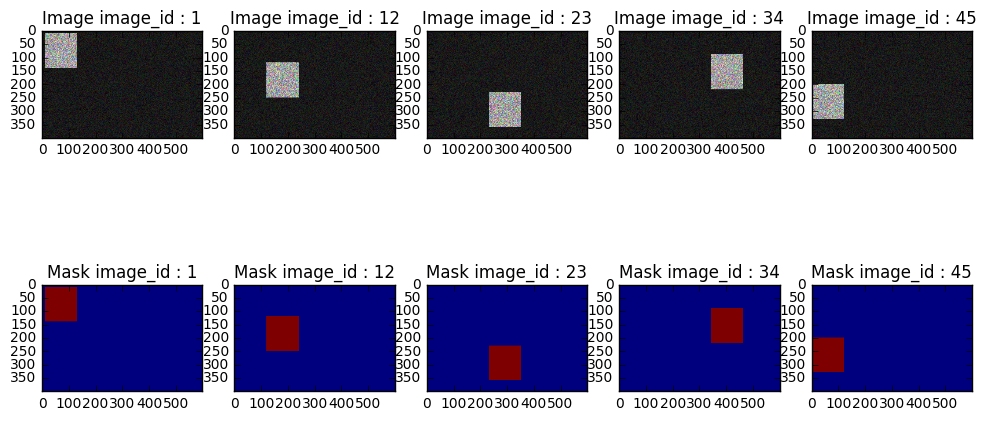

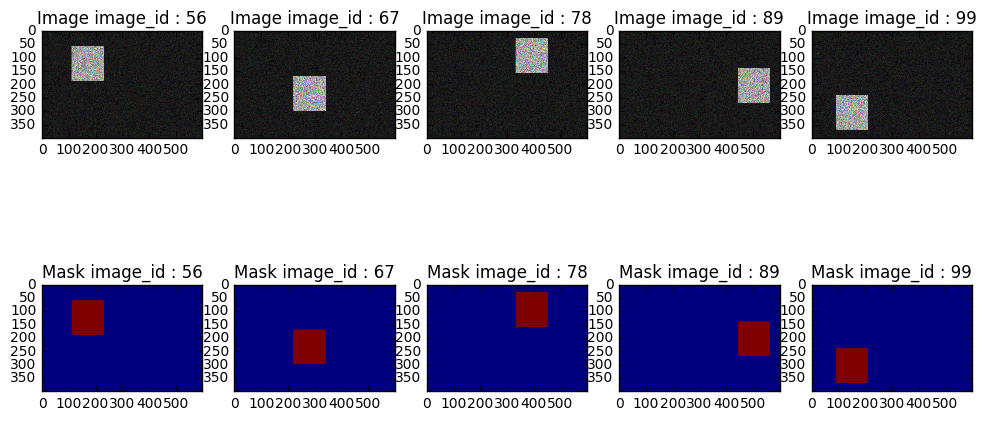

In [3]:
plt.figure(figsize=(12, 6))
for i, image_id in enumerate([1, 12, 23, 34, 45, 56, 67, 78, 89, 99]):
    if i % 5 == 0:
        plt.figure(figsize=(12, 6))
    plt.subplot(2,5,(i % 5) +1)
    plt.title("Image image_id : %i" % image_id)
    plt.imshow(get_image_data(image_id, 'image'))
    plt.subplot(2,5,(i % 5) + 5 + 1)
    plt.title("Mask image_id : %i" % image_id)
    plt.imshow(get_image_data(image_id, 'mask'))

Next, let us define an instance of `ImageMaskGenerator` with a pipeline of data augmentation:
```
pipeline=('random_transform', rgb_to_r, 'standardize')
```
It means that the generator will apply on the input data `random_transform` function, then a user-defined function `rgb_to_r` and, finally, the function `standardize`. The first and the last functions are provided by `keras` `ImageDataGenerator`. 

Other parameters are inherited from `keras` `ImageDataGenerator`. 

In [4]:
def rgb_to_rg(img, mask):
    out_img = img.copy()
    out_img[:, :, 2:] = 0
    return out_img, mask

train_gen = ImageMaskGenerator(pipeline=('random_transform', rgb_to_rg, 'standardize'),
                               featurewise_center=True,
                               featurewise_std_normalization=True,
                               rotation_range=15., 
                               width_shift_range=0.05, height_shift_range=0.05,
                               shear_range=3.14/6.0,
                               zoom_range=0.25,
                               horizontal_flip=True,
                               vertical_flip=True)

Next, we need to write a generator function that provides images and masks available for training or validation. Such generator should have a boolean option `infinite` that defines whether the generator loops forever (training phase) or reads once available data (validation phase):

In [5]:
import cv2

def xy_provider(image_ids, infinite=True):
    while True:
        for image_id in image_ids:
            img = get_image_data(image_id, 'image')
            mask = get_image_data(image_id, 'mask')    
            # Some custom processing : resize
            img = cv2.resize(img, dsize=(224, 224))
            mask = cv2.resize(mask, dsize=(224, 224))
            mask = np.expand_dims(mask, axis=2)
            
            img = img.astype(np.float32)
            img *= 1.0/255.0
            # Pay attention that you should respect image data format  
            yield img, mask, (image_id, )
        if not infinite:
            return

Arrays returned by generator function `xy_provider` should respect `image_data_format` defined in `train_gen`. By default it is the one returned by `keras.backend.image_data_format`

As we set `featurewise_center=True` and `featurewise_std_normalization=True`, we need to compute statistics of augmented data. In this case our `xy_provider` should not loop indefinitely. The argument `save_to_dir` allows to store computed statistics and reload it further.

In [6]:
train_image_ids = list(range(1, 101))

train_gen.fit(xy_provider(train_image_ids, infinite=False),
            len(train_image_ids), 
            augment=True, 
            save_to_dir=None, # '.',
            batch_size=4,
            verbose=1)

 96/100 [===========================>..] - ETA: 0s

In [7]:
train_gen.mean, train_gen.std

(array([[[ 0.13225495,  0.13221523,  0.        ]]]),
 array([[[ 0.14434274,  0.14419989,  0.        ]]]))

Now let us visualize the data provided by `train_gen` as if it was called by `model.fit_generator`  

In [8]:
batch_size = 5
flow = train_gen.flow(xy_provider(train_image_ids), # Infinite generator is used
                      len(train_image_ids),
                      batch_size=batch_size)

In [9]:
def normalize(in_img, q_min=0.5, q_max=99.5, return_mins_maxs=False):
    """
    Normalize image in [0.0, 1.0]
    mins is array of minima
    maxs is array of differences between maxima and minima
    """
    init_shape = in_img.shape
    if len(init_shape) == 2:
        in_img = np.expand_dims(in_img, axis=2)
    w, h, d = in_img.shape
    img = in_img.copy()
    img = np.reshape(img, [w * h, d]).astype(np.float64)
    mins = np.percentile(img, q_min, axis=0)
    maxs = np.percentile(img, q_max, axis=0) - mins
    maxs[(maxs < 0.0001) & (maxs > -0.0001)] = 0.0001
    img = (img - mins[None, :]) / maxs[None, :]
    img = img.clip(0.0, 1.0)
    img = np.reshape(img, [w, h, d])
    if init_shape != img.shape:
        img = img.reshape(init_shape)
    if return_mins_maxs:
        return img, mins, maxs
    return img

def scale_percentile(matrix, q_min=0.5, q_max=99.5):
    is_gray = False
    if len(matrix.shape) == 2:
        is_gray = True
        matrix = matrix.reshape(matrix.shape + (1,))
    matrix = (255*normalize(matrix, q_min, q_max)).astype(np.uint8)
    if is_gray:
        matrix = matrix.reshape(matrix.shape[:2])
    return matrix  

(5, 224, 224, 3) (5, 224, 224, 1)
Mean/Std value:  -0.0655226 0.66441
Mean/Std value:  -0.0171515 0.78397
Mean/Std value:  -0.0571339 0.688674
Mean/Std value:  -0.0850782 0.610827
Mean/Std value:  -0.0258499 0.755393


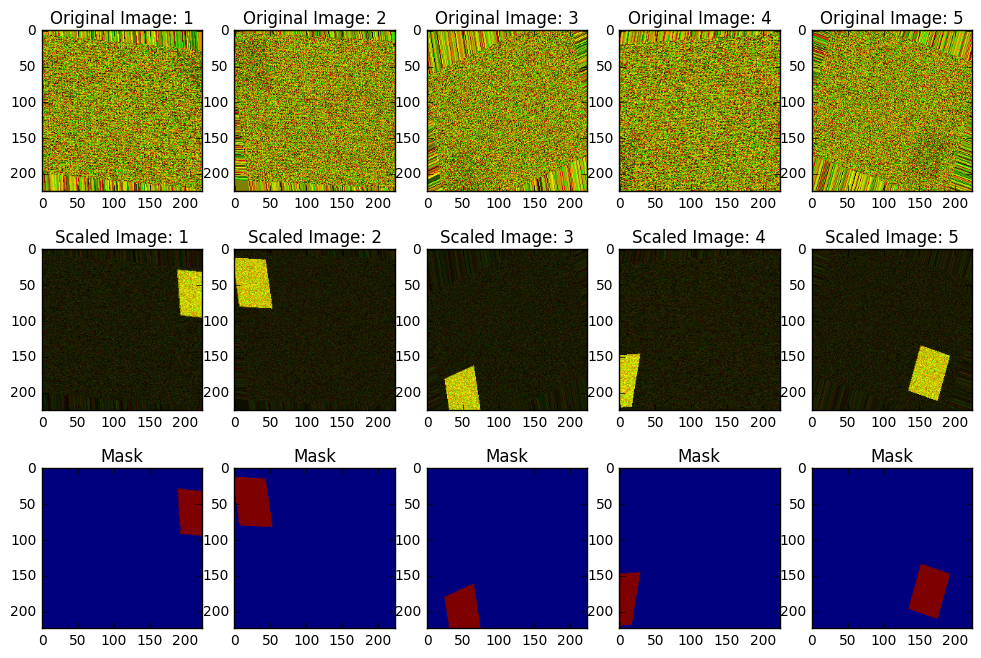

In [10]:
for x, y, info in flow:
    print(x.shape, y.shape)
    plt.figure(figsize=(12, 8))
    for i in range(batch_size):
        print("Mean/Std value: ", np.mean(x[i, :, :, :]), np.std(x[i, :, :, :]))
        plt.subplot(3,5,i+0*5+1)
        plt.title("Original Image: %s" % info[i])
        plt.imshow(x[i, :, :, :])
        plt.subplot(3,5,i+1*5+1)
        plt.title("Scaled Image: %s" % info[i])
        plt.imshow(scale_percentile(x[i, :, :, :]))
        plt.subplot(3,5,i+2*5+1)
        plt.title("Mask")
        plt.imshow(y[i, :, :, 0])
        
    break